In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


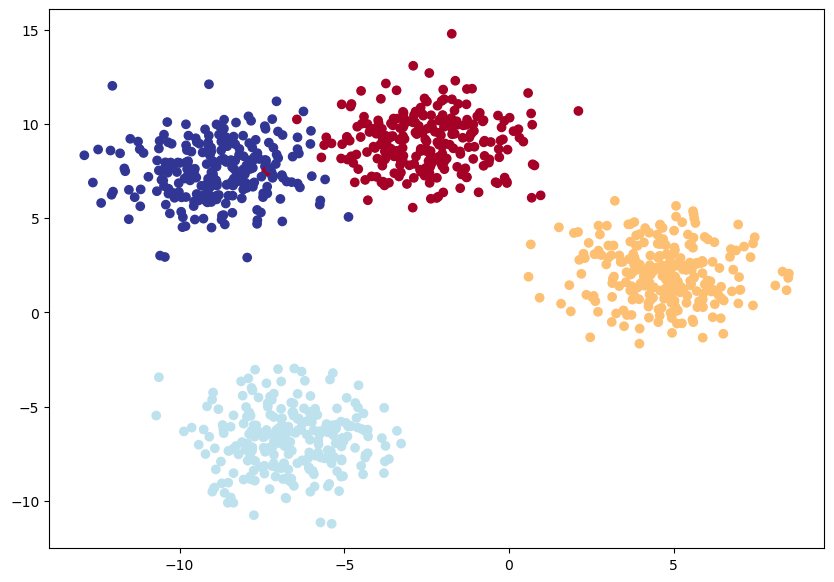

In [36]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, 
    centers=NUM_CLASSES, 
    cluster_std=1.5, 
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: \"{device}\"")

Using device: "cpu"


In [48]:
class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model = BlobModel(in_features=NUM_FEATURES,
                 out_features=NUM_CLASSES,
                 hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [49]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [50]:
torch.manual_seed(RANDOM_SEED)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                           lr=0.1)

In [51]:
model(X_blob_train.to(device))[:5] # logits
# predicting one value for each class

tensor([[ 0.8696, -0.7083, -0.3200,  0.5513],
        [-0.1989, -2.0320,  0.4267, -1.2864],
        [-0.9819, -0.0741,  1.0288, -1.7247],
        [-0.6449, -0.4877,  0.7777, -1.4029],
        [-0.2937, -1.7872,  0.4998, -1.3371]], grad_fn=<SliceBackward0>)

* `logits -> prediction probabilities -> prediction labels`: we use the softmax activation function
* this calculates the probability of of each prediction class being the actual predicted class compared to all the other possible classes

In [52]:
y_logits = model(X_blob_test.to(device))

# each sample here now adds to 1, meaning that it's a "probability distribution?"
# each sample: how much it maps to each class
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5]) 

tensor([[ 0.8161, -0.8846, -0.2847,  0.4252],
        [-0.9359, -2.0669,  0.9583, -2.2816],
        [-0.6742, -0.0694,  0.8067, -1.3123],
        [ 0.6858, -0.5307, -0.1840,  0.3610],
        [ 0.1430, -1.9414,  0.1816, -0.8017]], grad_fn=<SliceBackward0>)
tensor([[0.4563, 0.0833, 0.1518, 0.3087],
        [0.1215, 0.0392, 0.8077, 0.0316],
        [0.1289, 0.2361, 0.5669, 0.0681],
        [0.4102, 0.1215, 0.1719, 0.2964],
        [0.3918, 0.0487, 0.4072, 0.1523]], grad_fn=<SliceBackward0>)


In [53]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0])) # the most likely class

tensor([0.4563, 0.0833, 0.1518, 0.3087], grad_fn=<SelectBackward0>)
tensor(0)


In [58]:
epochs = 100

# put data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model.train()
    
    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_blob_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            
            test_loss = loss_fn(test_logits, y_blob_test)
            test_acc = accuracy_fn(y_true=y_blob_test,
                                  y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.92116, Acc: 26.00% | Test Loss: 0.85459, Test Acc: 55.00%
Epoch: 10 | Loss: 0.28521, Acc: 97.12% | Test Loss: 0.23787, Test Acc: 98.00%
Epoch: 20 | Loss: 0.11618, Acc: 99.00% | Test Loss: 0.10434, Test Acc: 98.50%
Epoch: 30 | Loss: 0.07650, Acc: 99.00% | Test Loss: 0.06791, Test Acc: 98.50%
Epoch: 40 | Loss: 0.06006, Acc: 99.00% | Test Loss: 0.05209, Test Acc: 99.00%
Epoch: 50 | Loss: 0.05133, Acc: 99.00% | Test Loss: 0.04346, Test Acc: 99.00%
Epoch: 60 | Loss: 0.04599, Acc: 99.00% | Test Loss: 0.03807, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04242, Acc: 99.00% | Test Loss: 0.03440, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03989, Acc: 99.00% | Test Loss: 0.03174, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03800, Acc: 99.00% | Test Loss: 0.02972, Test Acc: 99.50%


In [64]:
# make some predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)
print(f"Predictions:\t{y_preds[:10]}\nLabels:\t\t{y_blob_test[:10]}")

Predictions:	tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels:		tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


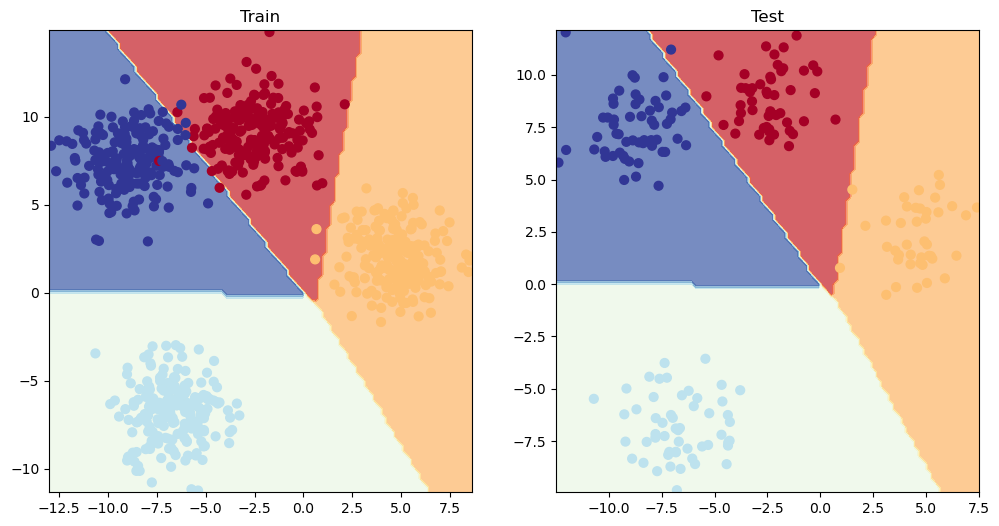

In [72]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)
plt.show()

#### Common evaluation metrics
* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [73]:
from torchmetrics import Accuracy

ModuleNotFoundError: No module named 'torchmetrics'